In [2]:
import sys
assert sys.version_info >= (3,5)

In [3]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [4]:
import pandas as pd

In [5]:
import numpy as np

In [6]:
import scipy.stats as stats

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from pandas.plotting import scatter_matrix

In [9]:
import time

In [10]:
import cv2

In [11]:
import seaborn as sns

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [15]:
from sklearn.metrics import accuracy_score, silhouette_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
from itertools import cycle

In [20]:
from sklearn.cluster import KMeans

In [21]:
complete_x_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_train_all.csv')
complete_y_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_train_all.csv')
complete_x_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_test_all.csv')
complete_y_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_test_all.csv')

In [22]:
complete_x_train = complete_x_train.copy().astype('float') / 255
complete_x_test = complete_x_test.copy().astype('float') / 255

In [23]:
dim = (48,48)

In [24]:
def process_image(image_path):
    # Read the image in grayscale
    pixel_array = image_path
    normalized_array = np.uint8(pixel_array*255)

    image_eq = cv2.equalizeHist(normalized_array)

    # Convert the image to binary using Otsu's method
    _, binary_image = cv2.threshold(image_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the number from the image
    number = normalized_array[y:y+h, x:x+w]

    return [number,h, w]

In [25]:
def img_denoiser(arr): 
    pixel_array = arr
    reshaped_array = pixel_array 
    normalized_array = np.uint8(reshaped_array*255)
    if normalized_array.ndim != 2:
        raise ValueError("The image should have 2 dimensions")
    
    # thresholded_image = cv2.resize(normalized_array,dim)
    thresholded_image = cv2.adaptiveThreshold(normalized_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY_INV, 7, 1)
    return thresholded_image


In [26]:
def simplify(arr):
    #im = process_image(np.array(arr).reshape(48,48))
    #ret = img_denoiser(cv2.resize(im[0].reshape(im[1],im[2]),dim))
    ret = img_denoiser(np.array(arr).reshape(48,48))
    im = process_image(ret)
    return cv2.resize(im[0].reshape(im[1],im[2]),dim)

In [27]:
complete_x_train_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_train.copy()).reshape(-1, dim[0]*dim[1])

complete_x_test_denoise = np.apply_along_axis(
    func1d=lambda img: simplify(img),
    axis=1, arr=complete_x_test.copy()).reshape(-1, dim[0]*dim[1])

complete_x_train_denoise = pd.DataFrame(complete_x_train_denoise)
complete_x_test_denoise = pd.DataFrame(complete_x_test_denoise)

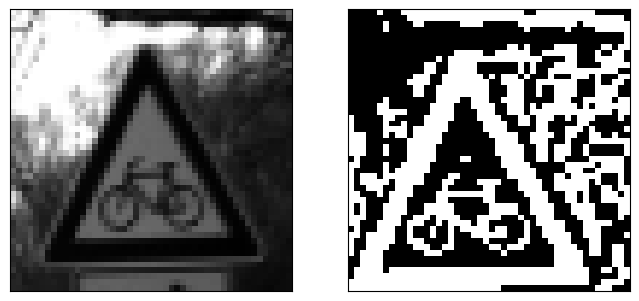

In [28]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train.iloc[9685].to_numpy().reshape(48,48),'gray')
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(complete_x_train_denoise.iloc[9685].to_numpy().reshape(dim),'gray')

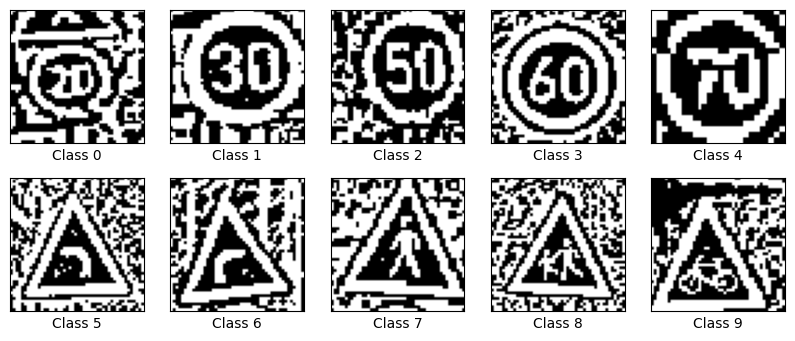

In [29]:
plt.figure(figsize=(10,4))

img_toshow = [0,210,2435,6085,7030,8275,8635,8875,9415,9685]

for i in range (0, len(img_toshow)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_train_denoise.iloc[img_toshow[i]].to_numpy().reshape(dim), cmap='gray')
    plt.xlabel("Class "+str(complete_y_train.iloc[img_toshow[i]].to_numpy()[0]))

In [30]:
joined_dataset = complete_x_train_denoise.copy()
joined_dataset['class']=complete_y_train.copy()

grouped_dataset = joined_dataset.groupby('class', group_keys=False)
avg_val = int(grouped_dataset['class'].value_counts().max())

In [31]:
balanced_dataset = pd.DataFrame()

for i in range(0,10):
        balanced_dataset = pd.concat([balanced_dataset, joined_dataset[joined_dataset['class']==i].sample(avg_val, replace=True)])

balanced_dataset_x = balanced_dataset.iloc[:,:dim[0]*dim[1]]
balanced_dataset_y = balanced_dataset.iloc[:,dim[0]*dim[1]:]

In [32]:
import numpy as np
from skimage.feature import hog
from skimage import exposure
 
# Assuming 'X' is your dataset where each row is a flattened image
X = balanced_dataset_x.to_numpy()  # Convert DataFrame to NumPy array if not already
 
# Define the dimensions of your images
image_height = 48  # Replace with actual image height
image_width = 48   # Replace with actual image width
 
# Function to compute HOG features for each image
def compute_hog_features(dataset, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    n_images = dataset.shape[0]
    # Determine the feature length once to initialize the feature matrix
    sample_feature_length = len(hog(dataset[0].reshape((image_height, image_width)),
                                    pixels_per_cell=pixels_per_cell,
                                    cells_per_block=cells_per_block,
                                    orientations=orientations,
                                    visualize=False))
    # Initialize the HOG feature matrix
    hog_features = np.zeros((n_images, sample_feature_length))
   
    # Compute HOG features for each image
    for i in range(n_images):
        image = dataset[i].reshape((image_height, image_width))
        hog_feature, _ = hog(image,
                             pixels_per_cell=pixels_per_cell,
                             cells_per_block=cells_per_block,
                             orientations=orientations,
                             visualize=True)
        hog_features[i] = hog_feature
       
    return hog_features
 
# Compute HOG features for the entire dataset
balanced_dataset_x = compute_hog_features(X)

In [33]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42, n_init=10)
kmeans.fit(balanced_dataset_x)

KMeans(n_clusters=10, n_init=10, random_state=42)

In [34]:
from sklearn.mixture import GaussianMixture
import numpy as np
 
# Assume 'X' is your dataset
X = balanced_dataset_x  # Convert DataFrame to NumPy array if necessary
 
# Initialize Gaussian Mixture Model
# n_components is the number of clusters (Gaussian distributions) to fit
gmm = GaussianMixture(n_components=10, random_state=42)
 
# Fit the model and predict clusters (soft clustering)
gmm.fit(X)
cluster_assignments = gmm.predict(X)
 
# For soft clustering (probabilities), you can use predict_proba
cluster_probs = gmm.predict_proba(X)

In [35]:
import matplotlib.pyplot as plt
 
# Assuming you know the height and width of the images
image_height = 48  # Replace with actual image height
image_width = 48   # Replace with actual image width
X= balanced_dataset_x.to_numpy()
# Reshape the dataset into the original image dimensions
images_2d = X.reshape((-1, image_height, image_width))
 
# Find the indices of images for each cluster
cluster_indices = {}
for cluster in range(gmm.n_components):
    cluster_indices[cluster] = np.where(cluster_assignments == cluster)[0]
 
# Plot one image from each cluster
fig, axs = plt.subplots(1, gmm.n_components, figsize=(20, 4))
fig.suptitle('One image from each GMM cluster', fontsize=16)
 
for i, indices in cluster_indices.items():
    if len(indices) > 0:  # If there are images in the cluster
        # Choose a random image index from this cluster
        image_idx = np.random.choice(indices)
        axs[i].imshow(images_2d[image_idx], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Cluster {i}')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
# kmeans_centroids,cluster=k_means(balanced_dataset_x.to_numpy(),10)

In [ ]:
X=balanced_dataset_x
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
# Assuming 'X' is your dataset and 'final_centroids' and 'final_assignments' are outputs from your k_means function
 
# Perform PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
centroids_pca = pca.transform(kmeans_centroids)
 
# Scatter plot of the data points
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=complete_y_train, cmap='viridis', marker='o', alpha=0.5, label='Data Points')
 
# Scatter plot of the centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=100, label='Centroids')
 
# Setting the plot title and labels
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
 
# Adding a legend to indicate which symbols represent the data points and which represent the centroids
plt.legend()
 
# Show the plot
plt.show()

NameError: name 'balanced_dataset_x' is not defined

In [ ]:
kmeans_centroids = kmeans.cluster_centers_
kmeans_centroids

array([[0.26733845, 0.        , 0.27404481, ..., 0.04182229, 0.        ,
        0.        ],
       [0.27787005, 0.        , 0.19143693, ..., 0.16464294, 0.        ,
        0.        ],
       [0.26414045, 0.        , 0.18686207, ..., 0.16791301, 0.        ,
        0.        ],
       ...,
       [0.27271702, 0.        , 0.15516945, ..., 0.13293855, 0.        ,
        0.        ],
       [0.23624744, 0.        , 0.26045247, ..., 0.03801415, 0.        ,
        0.        ],
       [0.21387162, 0.        , 0.22089529, ..., 0.12201031, 0.        ,
        0.        ]])

In [ ]:
# np.unique(kmeans.labels_)

In [ ]:
# y_pred = kmeans.predict(complete_x_test_denoise)

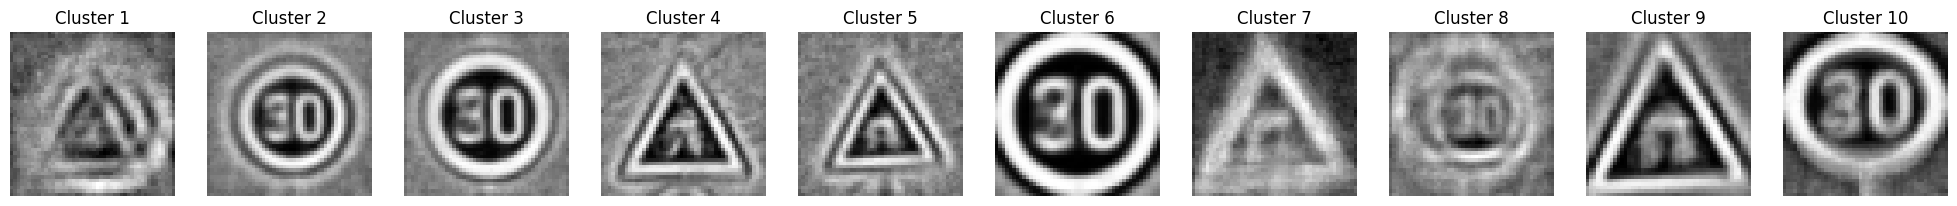

In [ ]:
import matplotlib.pyplot as plt
 
# Let's say each image is 28x28 pixels
image_height = 48
image_width = 48
 
# Number of clusters
k = 10
 
# Reshape centroids and plot them as images
fig, axes = plt.subplots(1, k, figsize=(25,18))
for i, centroid in enumerate(kmeans_centroids):
    # Reshape the centroid into the original image dimensions
    image = centroid.reshape(image_height, image_width)
   
    # Display the image
    ax = axes[i]
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Cluster {i+1}')
 
plt.show()

In [ ]:
y_actual = [i[0] for i in np.array(complete_y_test)]

In [ ]:
pred_results = pd.DataFrame({'actual':y_actual,'predicted':y_pred})
pred_results.head(10)

NameError: name 'y_pred' is not defined

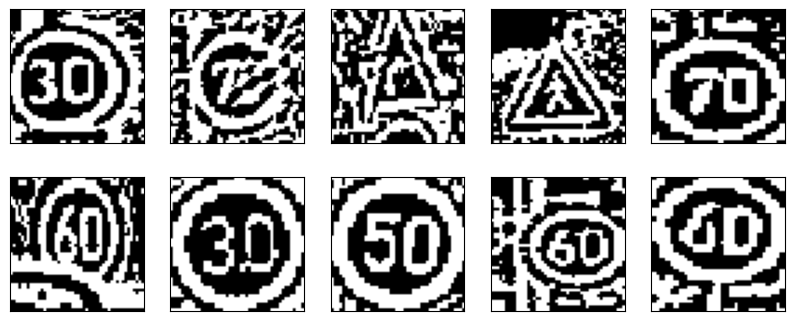

In [ ]:
plt.figure(figsize=(10,4))

for i in range (0, 10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(complete_x_test_denoise.iloc[i].to_numpy().reshape(dim), cmap='gray')

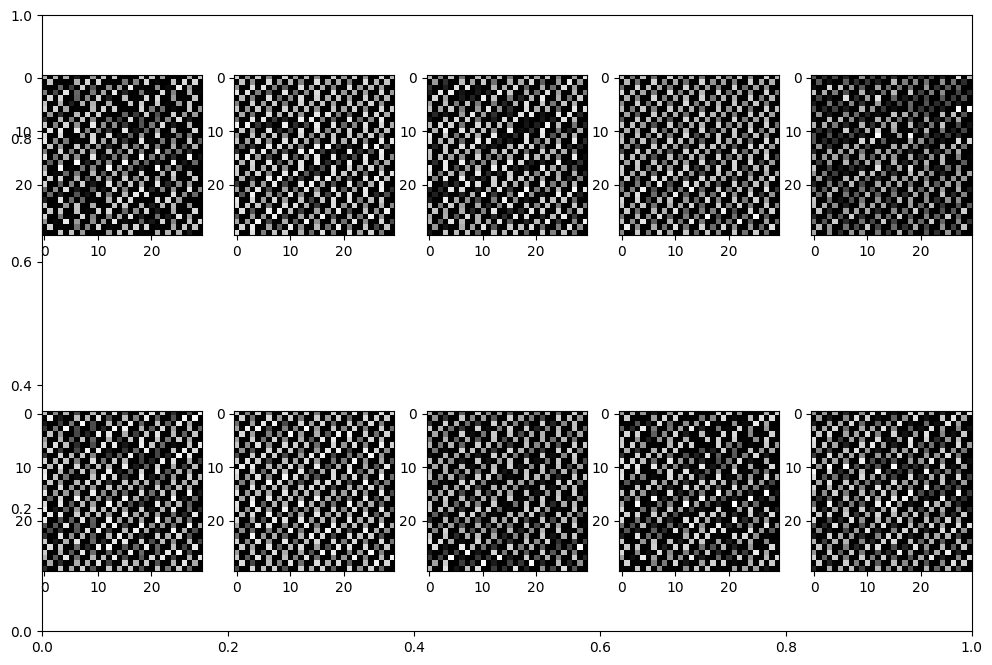

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
for centroid in range(len(kmeans_centroids)):
    plt.subplot(2,5,centroid+1)
    plt.imshow(kmeans_centroids[centroid].reshape(30,30),cmap='grey')

In [ ]:
accuracy_score(complete_y_test,y_pred)

0.032362459546925564

Average silhouette score: -0.28157591690630707


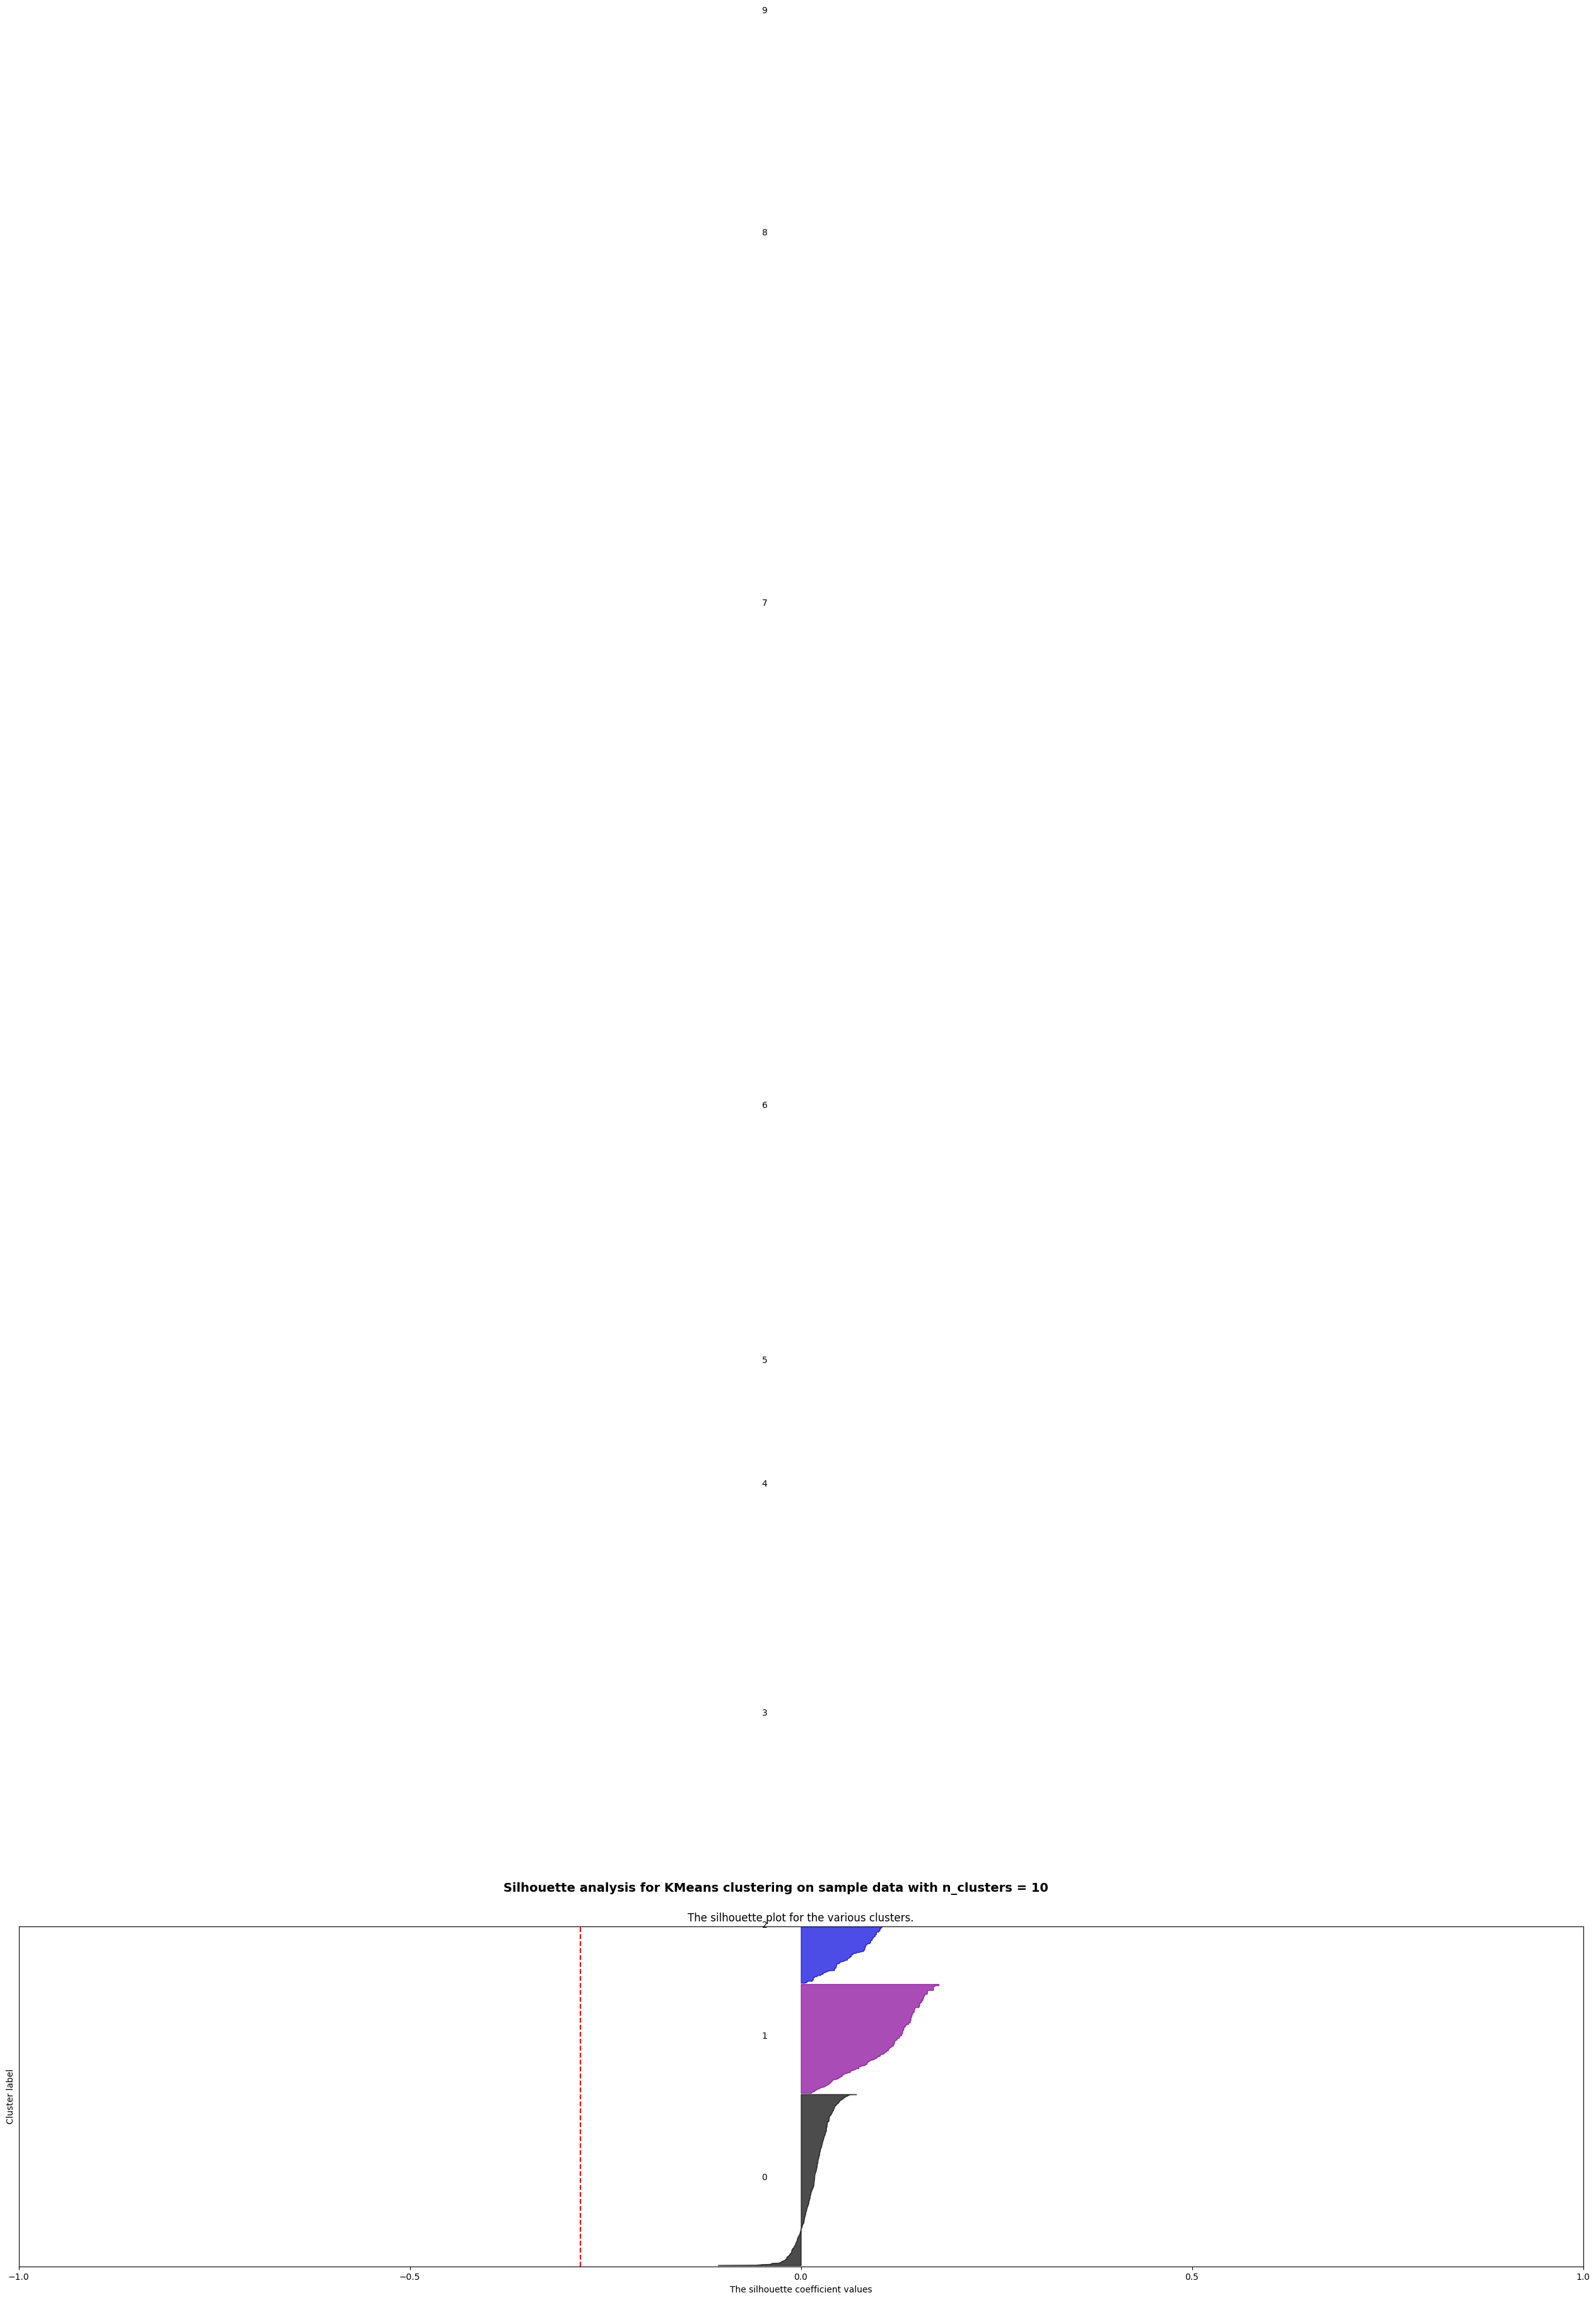

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
 
import matplotlib.cm as cm
 
# Assume 'X' is your feature matrix and 'final_assignments' are the labels from the clustering
# Ensure that 'X' is not the PCA-transformed dataset but the original feature set that was used for clustering
 
# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(balanced_dataset_x, cluster_assignments)
 
# Calculate the silhouette score average
silhouette_avg = silhouette_score(balanced_dataset_y, cluster_assignments)
print(f"Average silhouette score: {silhouette_avg}")
 
# Number of clusters
n_clusters = len(np.unique(cluster_assignments))
 
# Create a subplot with 1 row and 1 column
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
 
# The silhouette plot ranges from -1 to 1
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters
ax1.set_ylim([0, len(complete_x_test) + (n_clusters + 1) * 10])
 
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = silhouette_vals[cluster_assignments == i]
    ith_cluster_silhouette_values.sort()
 
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
 
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
 
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
 
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
 
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
 
plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
             fontsize=14, fontweight='bold')
 
plt.show()